# Lane Navigation via Nvidia Model

Code taken from DeepPiCar by David Tian and modified.

In [39]:
# initial variables
model_output_dir = 'trained_models'
debug_mode = True

## Imports Packages

In [40]:
# imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

if debug_mode:
    print( f'tf.__version__: {tf.__version__}' )
    print( f'keras.__version__: {tf.keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


tf.__version__: 2.8.0
keras.__version__: 2.8.0


## Load Train Data

In [41]:
def vector_from_filename(filename):
    vector_str = filename[:-4].split(' ')[1].split(':')
    return [float(vector_str[0]), float(vector_str[1])]


image_path: training_data/07-05-2022_18:11:45.759 0:0.3.jpg
steering_Angle: 90


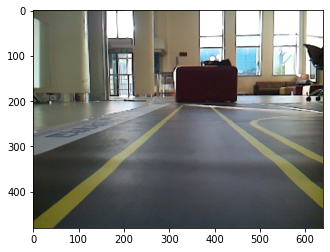

In [42]:
# import images
data_dir = 'training_data'
file_list = os.listdir(data_dir)
file_list.sort()
image_paths = []
angles = []
pattern = "*.jpg"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        vector = vector_from_filename(filename)
        if (vector[0] == 0 and vector[1] == 0) or vector[1] < 0: # if stopped or going back - ignore
            continue

        angle = np.degrees(np.arctan2(vector[1], vector[0]))
        angles.append(angle)
        image_paths.append(os.path.join(data_dir, filename))

if debug_mode:
    image_index = 20
    plt.imshow(Image.open(image_paths[image_index]))
    print("image_path: %s" % image_paths[image_index])
    print("steering_Angle: %d" % angles[image_index])

df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angles'] = angles

Training data: 846
Validation data: 212


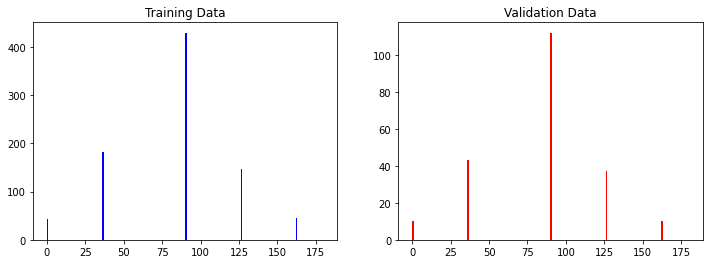

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

if debug_mode:
    # plot the distributions of train and valid, make sure they are consistent
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].hist(y_train, width=1, color='blue')
    axes[0].set_title('Training Data')
    axes[1].hist(y_valid, width=1, color='red')
    axes[1].set_title('Validation Data')


## Image Augumentation

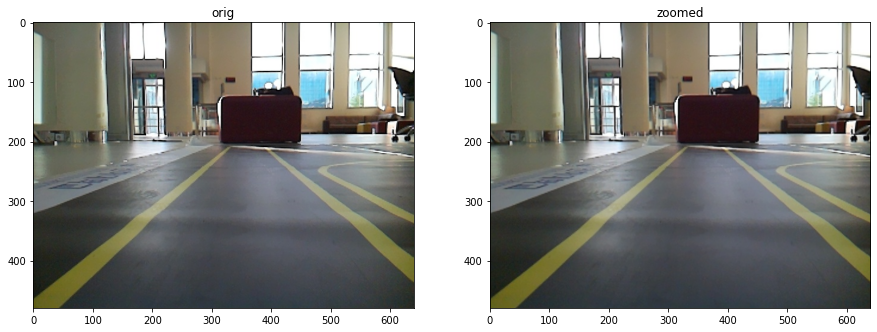

In [44]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom_aug = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom_aug.augment_image(image)
    return image

if debug_mode:
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    image_orig = my_imread(image_paths[image_index])
    image_zoom = zoom(image_orig)
    axes[0].imshow(image_orig)
    axes[0].set_title("orig")
    axes[1].imshow(image_zoom)
    axes[1].set_title("zoomed")

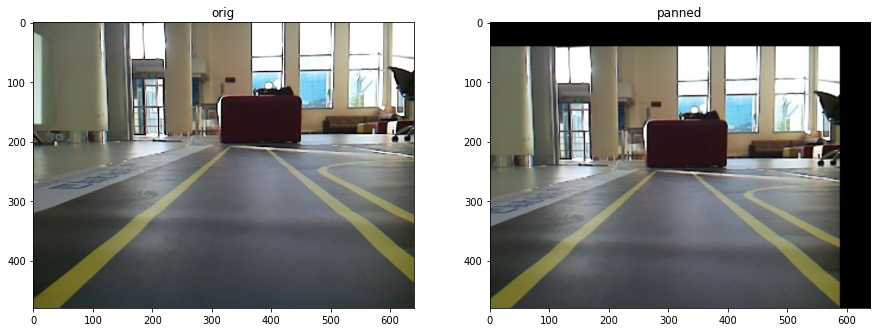

In [45]:
def pan(image):
    # pan left / right / up / down about 10%
    pan_aug = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan_aug.augment_image(image)
    return image

if debug_mode:
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    image_orig = my_imread(image_paths[image_index])
    image_pan = pan(image_orig)
    axes[0].imshow(image_orig)
    axes[0].set_title("orig")
    axes[1].imshow(image_pan)
    axes[1].set_title("panned")

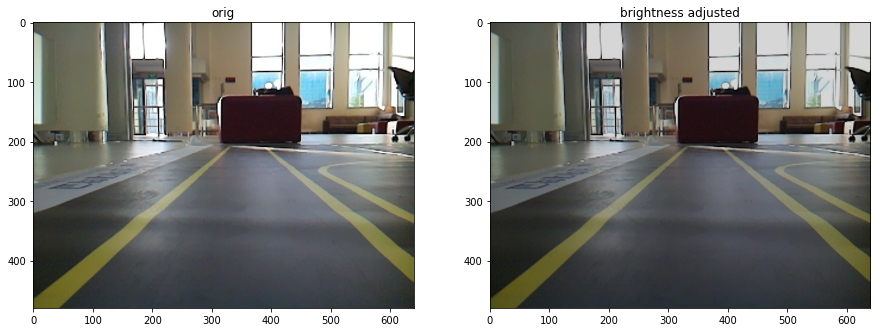

In [46]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

if debug_mode:
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    image_orig = my_imread(image_paths[image_index])
    image_brightness = adjust_brightness(image_orig)
    axes[0].imshow(image_orig)
    axes[0].set_title("orig")
    axes[1].imshow(image_brightness)
    axes[1].set_title("brightness adjusted")

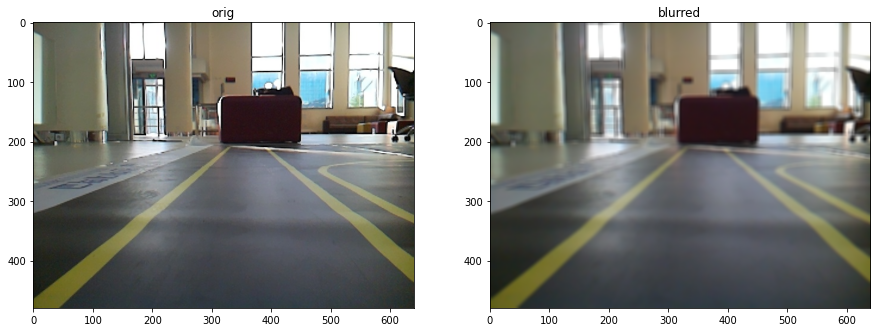

In [47]:
def blur(image):
    kernel_size = random.randint(1, 10)
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

if debug_mode:
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    image_orig = my_imread(image_paths[image_index])
    image_blur = blur(image_orig)
    axes[0].imshow(image_orig)
    axes[0].set_title("orig")
    axes[1].imshow(image_blur)
    axes[1].set_title("blurred")

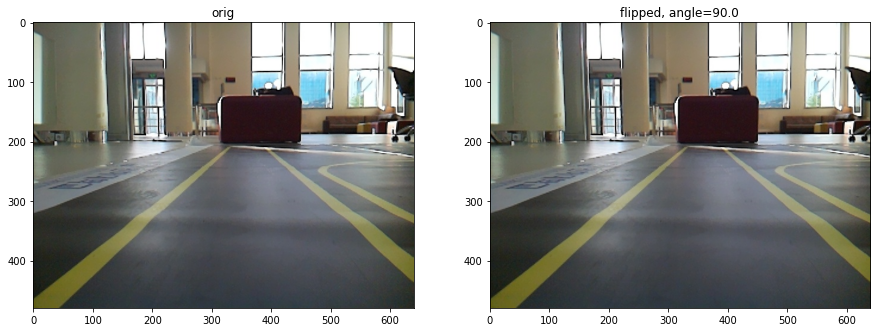

In [48]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizontally
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

if debug_mode:
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    image_orig = my_imread(image_paths[image_index])
    image_flip, steering_angle = random_flip(image_orig, angles[image_index])
    axes[0].imshow(image_orig)
    axes[0].set_title("orig")
    axes[1].imshow(image_flip)
    axes[1].set_title("flipped, angle=%s" % steering_angle)

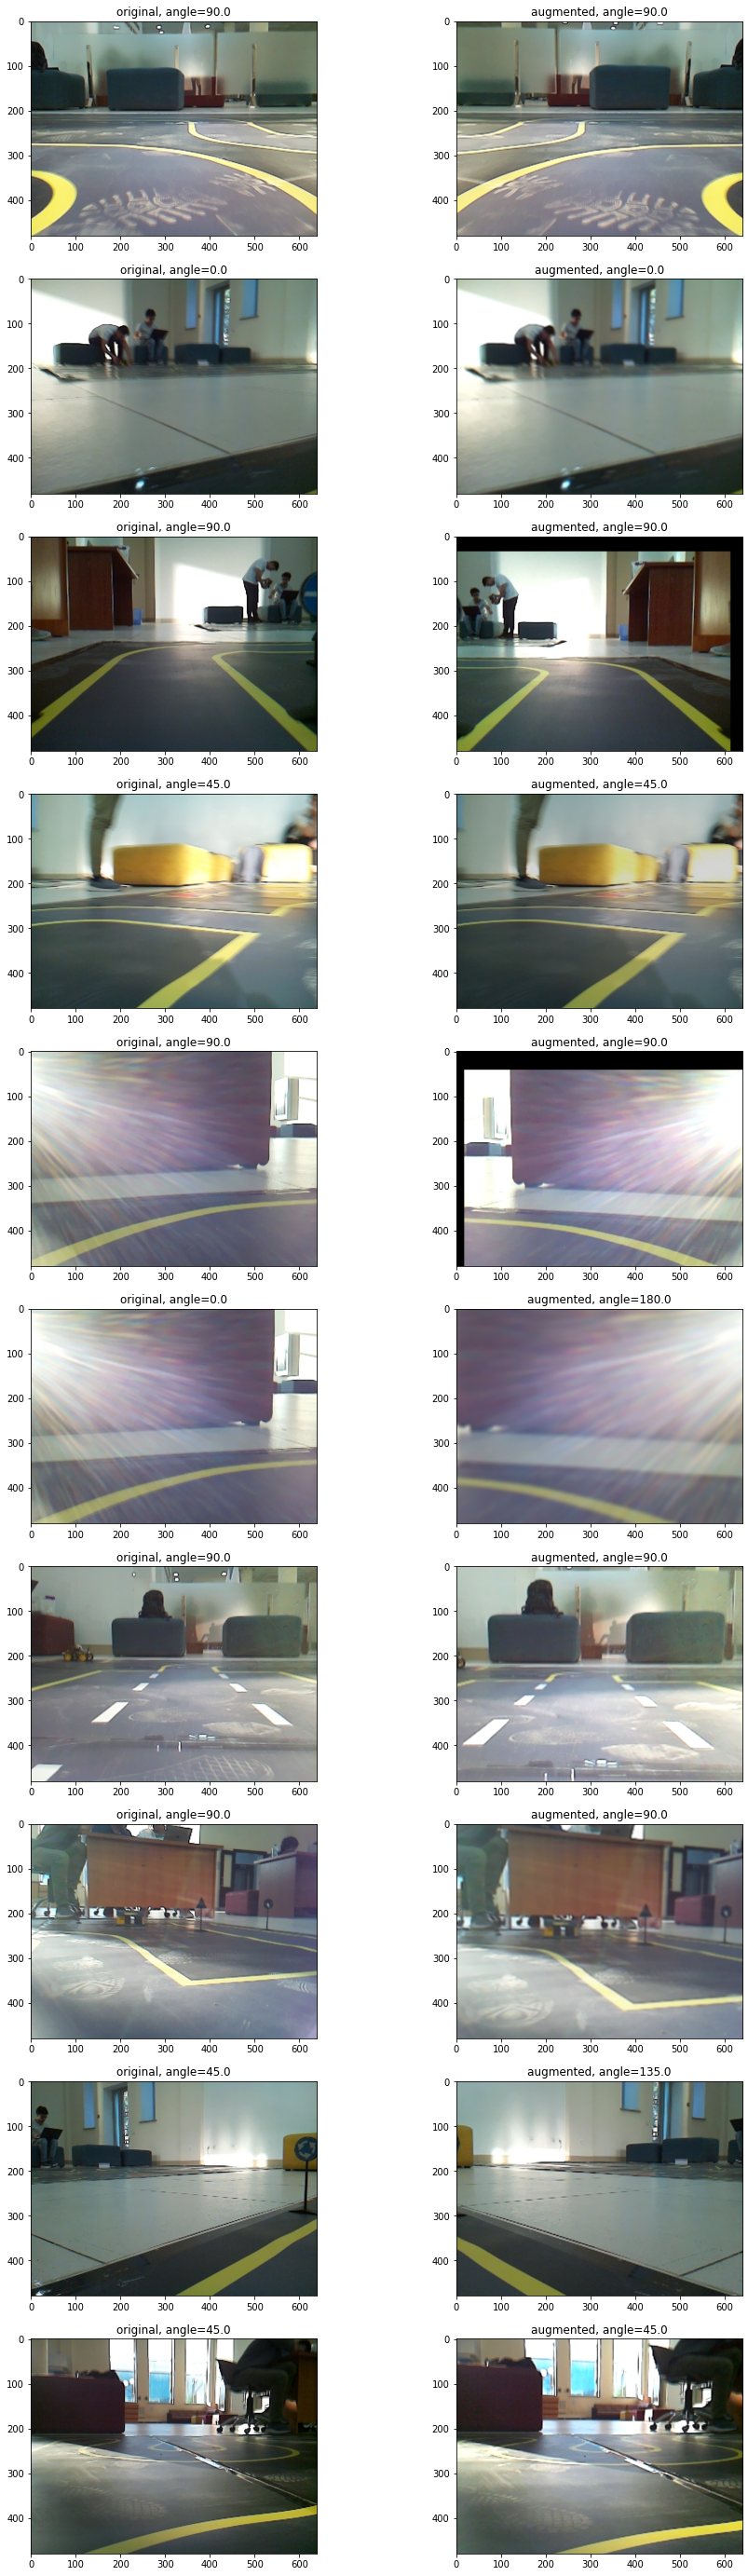

In [49]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

if debug_mode:
    # show a few randomly augmented images
    ncol = 2
    nrow = 10
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

    for i in range(nrow):
        rand_index = random.randint(0, len(image_paths) - 1)
        image_path = image_paths[rand_index]
        steering_angle_orig = angles[rand_index]

        image_orig = my_imread(image_path)
        image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)

        axes[i][0].imshow(image_orig)
        axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
        axes[i][1].imshow(image_aug)
        axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)

## Preprocess Training Data for Nvidia Model

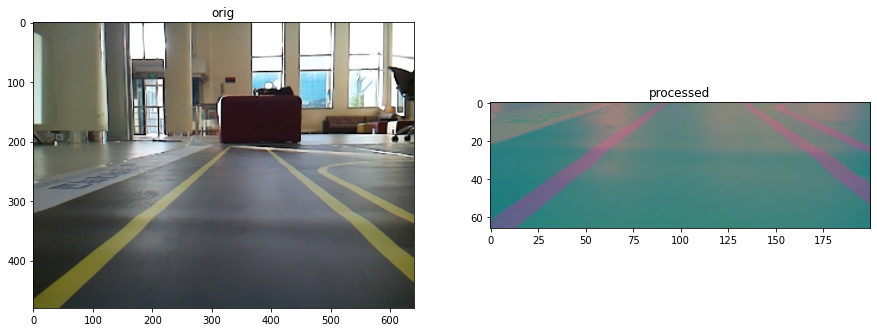

In [50]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    return image

if debug_mode:
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    image_orig = my_imread(image_paths[image_index])
    image_processed = img_preprocess(image_orig)
    axes[0].imshow(image_orig)
    axes[0].set_title("orig")
    axes[1].imshow(image_processed)
    axes[1].set_title("processed")


## Create and Train Model

In [51]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Exponential Linear Unit, similar to leaky Relu
    # skipping 1st hidden layer (normalization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, >90 turn left, <90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [52]:
model = nvidia_model()
if debug_mode:
    print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 dropout_4 (Dropout)         (None, 3, 20, 64)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 1152)             

In [53]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

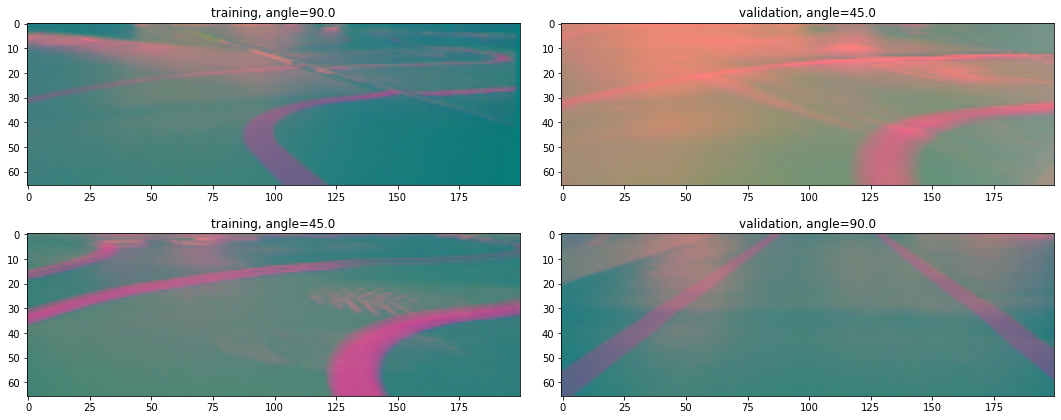

In [55]:
if debug_mode:
    ncol = 2
    nrow = 2

    X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
    X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
    fig.tight_layout()

    for i in range(nrow):
        axes[i][0].imshow(X_train_batch[i])
        axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
        axes[i][1].imshow(X_valid_batch[i])
        axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])


In [56]:
# this block prevents the training from starting if we Run All
DO_NOT_RUN_ALL

NameError: name 'DO_NOT_RUN_ALL' is not defined

In [57]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator(X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

/tmp/ipykernel_15723/4008534.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data_generator(X_train, y_train, batch_size=100, is_training=True),


Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 1779.1908
Epoch 1: val_loss improved from inf to 1589.58191, saving model to trained_models/lane_navigation_check.h5
300/300 [==============================] - 256s 855ms/step - loss: 1779.1908 - val_loss: 1589.5819
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 1634.1104
Epoch 2: val_loss improved from 1589.58191 to 1554.62952, saving model to trained_models/lane_navigation_check.h5
300/300 [==============================] - 263s 878ms/step - loss: 1634.1104 - val_loss: 1554.6295
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 1635.6932
Epoch 3: val_loss did not improve from 1554.62952
300/300 [==============================] - 267s 894ms/step - loss: 1635.6932 - val_loss: 1556.4882
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 1689.9053
Epoch 4: val_loss improved from 1554.62952 to 1527.35754, saving model to trained_models/lane_navigation_check.h

## Check Trained Model on Validation Data

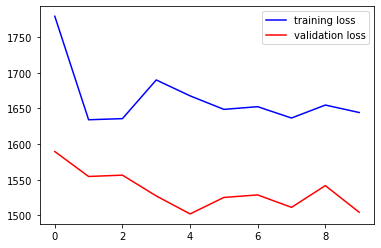

In [58]:
if debug_mode:
    # plot training and validation losses
    # this should be the same as tensorboard
    history_path = os.path.join(model_output_dir,'history.pickle')
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    plt.plot(history['loss'],color='blue')
    plt.plot(history['val_loss'],color='red')
    plt.legend(["training loss", "validation loss"])

In [59]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict(x):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    y_pred = model.predict(x)
    return y_pred

mse       = 1.7e+03
r_squared = -0.02%



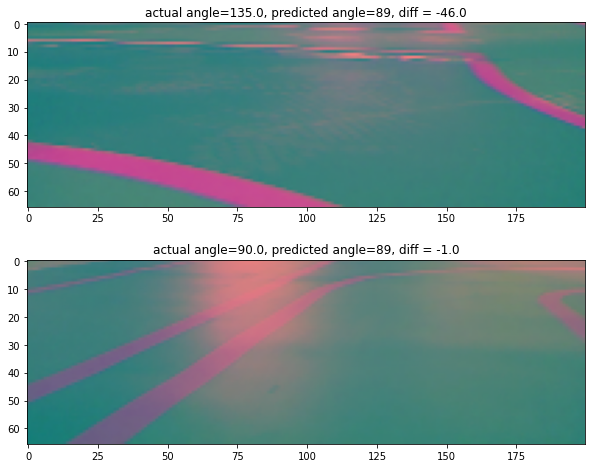

In [61]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, n_tests, False))

y_pred = predict(X_test)
summarize_prediction(y_test, y_pred)

if debug_mode:
    n_tests_show = 2
    fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
    for i in range(n_tests_show):
        axes[i].imshow(X_test[i])
        axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    

As we can see the $R^2$ of the predicted was around 95% and Mean Squared Errors (MSE) are low, indicating the model is predicting a steering angle every similar to our hand coded land follower, which was used as the model input.

## References
1. Mariusz Bojarski, Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel, Mathew Monfort, Urs Muller, Jiakai Zhang, Xin Zhang, Jake Zhao, Karol Zieba (2016) *End to End Learning for Self-Driving Cars*. Nvidia
1. Rayan Slim, Amer Sharaf, Jad Slim (2017) *The Complete Self-Driving Car Course*. Udemy
1. Keras Documentation (2019) https://github.com/keras-team/keras/